# Week 3 Assignment - Applied Data Science Capstone

## __A.   Scraping Wikipedia page & generate/clean-up dataframe__

Installing needed packages

In [2]:
!conda install -c conda-forge BeautifulSoup4 --yes
!conda install -c conda-forge lxml --yes
!conda install -c conda-forge html5lib --yes
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

Solving environment: done


==> WARN

In [4]:
#import packages

%matplotlib inline

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#clustering module
from sklearn.cluster import KMeans

#Data analysis library
import pandas as pd

#Handling vectorized data
import numpy as np

#html-parsers and readers used for pandas
import lxml
import html5lib
from bs4 import BeautifulSoup

#geo-locators and plotters
from geopy import Nominatim
import folium
import requests

Easy way to read html files containing tables

In [5]:
html_table = pd.read_html("Wikipedia.html")

First table is our wikitable

In [6]:
df = html_table[0]

Ignore all the _Not assigned_ cells in __Borough__

In [7]:
df = df[df.Borough != "Not assigned"]

_Wikipedia already has them merged. Change "/" separtion for ","._

In [8]:
#df.groupby(["Postal code"]).agg({"Borough": foo,
#                                "Neighborhood": foo}).reset_index()
df.Neighborhood.replace({"/":","},regex=True,inplace=True)

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


For columns having Borough but no Neighborhood, Neighborhood=Borough. Seems to have been corrected in the Wikipedia page as well

In [9]:
df.Neighborhood[df.Neighborhood=="Not assigned"] = df.loc[df.Neighborhood=="Not assigned","Borough"]
df.reset_index(drop=True)

print("The number of rows in our dataframe is: ", df.shape[0])

The number of rows in our dataframe is:  103


/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/srv/conda/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


## __B.   Foursquare location data addition__

Import the Geospatial_Coordinates datafile

In [10]:
geo = pd.read_csv("Geospatial_Coordinates.csv")
geo.head()


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge the two data sets if the Postal Code values match and drop the common column.

In [11]:
df_geo = pd.merge(df, geo, how="left", left_on="Postal code", right_on="Postal Code")
df_geo.drop(columns=["Postal Code"], inplace=True)
df_geo.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494


## __C.   Using k-means to cluster the neighborhoods in Toronto__

## 1. Plot geolocation and get overview of the neighborhoods

Import needed packages to get geolocations and for map rendering

In [29]:
from geopy.geocoders import Nominatim
import folium
import requests

Get geolocation of Toronto

In [12]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Create map of Toronto with neighborhoods superimposed on top

In [13]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_geo['Latitude'], df_geo['Longitude'], df_geo['Borough'], df_geo['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## 2. Focus on all boroughs that contain _Toronto_ in their name.

In [14]:
toronto_data = df_geo[df_geo['Borough'].str.contains('Toronto')].reset_index(drop=True)
toronto_data.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park , Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


Let us visualize only those neighborhoods.

In [15]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Define Foursquare Credentials and Version

In [16]:
CLIENT_ID = 'QGOKQAMT4MBY3SFUTOYGYPVBFDWL1Y00O2ZLRDGXRKXIDC3K' # Foursquare ID
CLIENT_SECRET = 'PVGILQ3IUIEVZLDOUCTH0JA0W03F4FQHCZNSSKODPUQRKCA2' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QGOKQAMT4MBY3SFUTOYGYPVBFDWL1Y00O2ZLRDGXRKXIDC3K
CLIENT_SECRET:PVGILQ3IUIEVZLDOUCTH0JA0W03F4FQHCZNSSKODPUQRKCA2


Choose venue limit and define function to get all the neighborhoods' names, their geo-locations and make a venue request on foursquare API

In [17]:
LIMIT=100 #limit of number of venues returned by Foursquare API


def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Code to call the function

In [18]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude'],
                                  )


Regent Park , Harbourfront
Queen's Park , Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond , Adelaide , King
Dufferin , Dovercourt Village
Harbourfront East , Union Station , Toronto Islands
Little Portugal , Trinity
The Danforth West , Riverdale
Toronto Dominion Centre , Design Exchange
Brockton , Parkdale Village , Exhibition Place
India Bazaar , The Beaches West
Commerce Court , Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park , The Junction South
North Toronto West
The Annex , North Midtown , Yorkville
Parkdale , Roncesvalles
Davisville
University of Toronto , Harbord
Runnymede , Swansea
Moore Park , Summerhill East
Kensington Market , Chinatown , Grange Park
Summerhill West , Rathnelly , South Hill , Forest Hill SE , Deer Park
CN Tower , King and Spadina , Railway Lands , Harbourfront West , Bathurst  Quay , South Niagara , Island airport
Rosed

Check size of the resulting dataframe, how many venues were returned and how many unique categories we can find:

In [19]:
print("The size of the dataframe is: ", toronto_venues.shape)

toronto_venues.groupby('Neighborhood').count() #number of venues for each neighborhood

The size of the dataframe is:  (1682, 7)


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,55,55,55,55,55,55
"Brockton , Parkdale Village , Exhibition Place",22,22,22,22,22,22
Business reply mail Processing CentrE,16,16,16,16,16,16
"CN Tower , King and Spadina , Railway Lands , Harbourfront West , Bathurst Quay , South Niagara , Island airport",16,16,16,16,16,16
Central Bay Street,78,78,78,78,78,78
Christie,19,19,19,19,19,19
Church and Wellesley,79,79,79,79,79,79
"Commerce Court , Victoria Hotel",100,100,100,100,100,100
Davisville,36,36,36,36,36,36


In [20]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 235 uniques categories.


## 3. Analyze Each Neighborhood

In [21]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print("The size of the dataframe is: ", toronto_onehot.shape)

The size of the dataframe is:  (1682, 235)


Mean of the frequency of occurence of each category

In [22]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print("The size of the new dataframe with means is: ",toronto_grouped.size)

The size of the new dataframe with means is:  9165


Print each neighborhood with the top 10 venues (in descending order):

In [23]:
num_top_venues = 10

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Bakery,Seafood Restaurant,Farmers Market,Restaurant,Café,Beer Bar,Department Store
1,"Brockton , Parkdale Village , Exhibition Place",Café,Coffee Shop,Breakfast Spot,Pet Store,Stadium,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue,Bakery
2,Business reply mail Processing CentrE,Yoga Studio,Auto Workshop,Comic Shop,Park,Pizza Place,Burrito Place,Restaurant,Brewery,Light Rail Station,Smoke Shop
3,"CN Tower , King and Spadina , Railway Lands , ...",Airport Terminal,Airport Lounge,Airport Service,Rental Car Location,Boat or Ferry,Coffee Shop,Boutique,Harbor / Marina,Bar,Airport Gate
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Burger Joint,Japanese Restaurant,Thai Restaurant,Gym / Fitness Center,Spa,Ice Cream Shop,Café


## 4. Cluster the Neighborhoods

How many clusters should one use? 

The elbow method: with each cluster the sum of squared distances decreases, evntually converging to zero if each point is a cluster. The optimal amount of clusters per point is given by the "elbow" if the plot is seen as an arm.

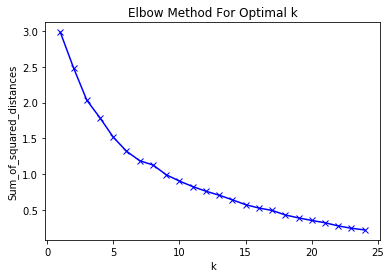

In [32]:
# set number of clusters
kclusters = range(1,25)
sum_of_squared_distances=[]

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
toronto_grouped_clustering

# run k-means clustering
for k in kclusters:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

#Plot the sum of squared distances aginst the number of clusters
plt.plot(kclusters, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The plot shows that the squared distances are very small! 2 clusters would suffise, the elbow is at kclusters=6. As the sum of squared distances variation is small, the cluster seem to be very similar.

For the sake of interpretation, let's therefore stick to 2 clusters.

In [33]:
# set number of clusters
kclusters = 2
sum_of_squared_distances=[]

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
toronto_grouped_clustering

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
sum_of_squared_distances.append(kmeans.inertia_)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.tail() # check the last columns!

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,0,Coffee Shop,Seafood Restaurant,Restaurant,Café,Japanese Restaurant,Beer Bar,Cocktail Bar,Hotel,Cheese Shop,Cosmetics Shop
35,M4X,Downtown Toronto,"St. James Town , Cabbagetown",43.667967,-79.367675,0,Coffee Shop,Chinese Restaurant,Restaurant,Pub,Café,Italian Restaurant,Bakery,Pizza Place,Park,Breakfast Spot
36,M5X,Downtown Toronto,"First Canadian Place , Underground city",43.648429,-79.382280,0,Coffee Shop,Café,Restaurant,Asian Restaurant,Seafood Restaurant,Hotel,Japanese Restaurant,Gastropub,Gym,American Restaurant
37,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,0,Coffee Shop,Japanese Restaurant,Gay Bar,Restaurant,Sushi Restaurant,Hotel,Men's Store,Mediterranean Restaurant,Yoga Studio,Gastropub
38,M7Y,East Toronto,Business reply mail Processing CentrE,43.662744,-79.321558,0,Yoga Studio,Auto Workshop,Comic Shop,Park,Pizza Place,Burrito Place,Restaurant,Brewery,Light Rail Station,Smoke Shop


Visualize the resulting clusters!

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine the Clusters

Cluster 1: Contains mostly shops (coffee shops, clothing stores, restaurant and bars)

In [35]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Coffee Shop,Pub,Park,Bakery,Mexican Restaurant,Café,Restaurant,Breakfast Spot,Event Space,Hotel
1,Downtown Toronto,0,Coffee Shop,Creperie,Beer Bar,Boutique,Burger Joint,Burrito Place,Restaurant,Café,Park,College Auditorium
2,Downtown Toronto,0,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Bubble Tea Shop,Middle Eastern Restaurant,Cosmetics Shop,Tea Room,Bookstore,Diner
3,Downtown Toronto,0,Coffee Shop,Café,Restaurant,American Restaurant,Beer Bar,Cosmetics Shop,Bakery,Diner,Japanese Restaurant,Italian Restaurant
4,East Toronto,0,Pub,Coffee Shop,Trail,Health Food Store,Doner Restaurant,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run
5,Downtown Toronto,0,Coffee Shop,Cocktail Bar,Cheese Shop,Bakery,Seafood Restaurant,Farmers Market,Restaurant,Café,Beer Bar,Department Store
6,Downtown Toronto,0,Coffee Shop,Italian Restaurant,Sandwich Place,Burger Joint,Japanese Restaurant,Thai Restaurant,Gym / Fitness Center,Spa,Ice Cream Shop,Café
7,Downtown Toronto,0,Grocery Store,Café,Park,Coffee Shop,Nightclub,Baby Store,Candy Store,Gas Station,Diner,Athletics & Sports
8,Downtown Toronto,0,Restaurant,Coffee Shop,Café,Gym,Bar,Bakery,Thai Restaurant,Asian Restaurant,Salad Place,Breakfast Spot
9,West Toronto,0,Pharmacy,Bakery,Grocery Store,Café,Bar,Bank,Supermarket,Pool,Middle Eastern Restaurant,Art Gallery


Cluster 2: Playground and Summer Camp. As seen on the map, surrounded by green spots like parks and the cemetery.

In [36]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Central Toronto,1,Playground,Summer Camp,Women's Store,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


### Conclusion: Taking only a subset of boroughs, does not give a lot of meaningful clusters as the neighborhoods are too similar to be differentiated.